### Importando bibliotecas necessárias para o experimento

In [1]:
import os
import numpy as np
import pandas as pd

import lightning as L
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
import torch.nn.init as init

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA

### Carregando csv de treino, teste e validação

In [2]:
train_original = pd.read_csv('dataset/hars/train.csv')
df_test = pd.read_csv('dataset/hars/test.csv') # dataframe de teste

df_train, df_val = train_test_split(train_original, test_size=0.2, random_state=42) # dataframes de treino e validacao

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

# removendo coluna subject
df_train.drop(columns=['subject'], inplace=True)
df_test.drop(columns=['subject'], inplace=True)
df_val.drop(columns=['subject'], inplace=True)

# remapeando activity para seu respectivo valor numerivo
atividades = {
    'LAYING': 0, 
    'WALKING_UPSTAIRS': 1, 
    'STANDING': 2, 
    'WALKING': 3, 
    'SITTING': 4, 
    'WALKING_DOWNSTAIRS': 5
}
df_train['Activity'] = df_train['Activity'].map(atividades)
df_test['Activity'] = df_test['Activity'].map(atividades)
df_val['Activity'] = df_val['Activity'].map(atividades)

# Armazenar as colunas "Activity" removidas
y_train = df_train.pop('Activity')
y_test = df_test.pop('Activity')
y_val = df_val.pop('Activity')

print("shape train: ", df_train.shape)
print("shape test: ", df_test.shape)
print("shape valid: ", df_val.shape)

shape train:  (5881, 561)
shape test:  (2947, 561)
shape valid:  (1471, 561)


In [3]:
df_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.278007,-0.017803,-0.108965,-0.994425,-0.994873,-0.994886,-0.994939,-0.993994,-0.995450,-0.938974,...,0.394506,-0.684497,-0.901888,0.751089,0.626432,0.263401,-0.646225,0.398881,-0.546717,-0.431200
1,0.237617,-0.000782,-0.114476,-0.326331,0.069663,-0.224321,-0.343326,0.039623,-0.256327,-0.310961,...,0.052089,-0.131946,-0.591721,0.628099,-0.357089,-0.925512,0.110212,-0.474013,0.383162,0.238969
2,0.290924,-0.050878,-0.073518,-0.026220,-0.032163,0.393109,-0.118256,-0.030279,0.432861,0.370607,...,-0.038923,-0.643660,-0.935668,-0.182993,0.484857,-0.961034,0.147325,-0.819001,0.221549,-0.003571
3,0.275268,-0.015050,-0.114204,-0.981092,-0.901124,-0.960423,-0.984417,-0.901405,-0.965788,-0.922291,...,-0.145084,-0.326860,-0.645937,0.205896,-0.168239,-0.197557,0.328892,-0.744428,0.274256,0.031246
4,0.278790,-0.018585,-0.106908,-0.997380,-0.983893,-0.984482,-0.997331,-0.985196,-0.983768,-0.942062,...,0.096524,-0.113724,-0.445144,-0.267371,-0.304399,-0.081555,0.110146,-0.615329,0.322236,0.161577


### Feature Selection

In [5]:
# from sklearn.feature_selection import SelectKBest, f_classif

# # Selecionar 360 features mais relevantes
# selector = SelectKBest(f_classif, k=360)
# fs_train = selector.fit_transform(df_train.values, y_train.values)
# fs_test = selector.fit_transform(df_test.values, y_test.values)
# fs_val = selector.fit_transform(df_val.values, y_val.values)

In [4]:
# from sklearn.feature_selection import SelectKBest, f_regression

# # Selecionar 360 features mais relevantes
# selector = SelectKBest(f_regression, k=360)
# fs_train = selector.fit_transform(df_train.values, y_train.values)
# fs_test = selector.fit_transform(df_test.values, y_test.values)
# fs_val = selector.fit_transform(df_val.values, y_val.values)

In [4]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Selecionar 360 features mais relevantes
selector = SelectKBest(mutual_info_classif, k=360)
fs_train = selector.fit_transform(df_train.values, y_train.values)
fs_test = selector.fit_transform(df_test.values, y_test.values)
fs_val = selector.fit_transform(df_val.values, y_val.values)

In [4]:
# from sklearn.feature_selection import SelectKBest, mutual_info_regression

# # Selecionar 360 features mais relevantes
# selector = SelectKBest(mutual_info_regression, k=360)
# fs_train = selector.fit_transform(df_train.values, y_train.values)
# fs_test = selector.fit_transform(df_test.values, y_test.values)
# fs_val = selector.fit_transform(df_val.values, y_val.values)

### PCA
- reduzir dimensionalidade do dataset para 360 (indicado pelo dataset que o professor irá usar)

In [4]:
# normalizando df_train, df_test e df_val
X_train = df_train.values
X_test = df_test.values
X_val = df_val.values

scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)
X_scaled_val = scaler.fit_transform(X_val)

In [5]:
# aplicando PCA
n_components = 360 # precisa ser igual a quantidade de features do dataframe que o professor vai usar

# treino
pca_train = PCA(n_components=n_components)
X_pca_train = pca_train.fit_transform(X_train) # X_scaled_train

print(X_pca_train.shape)

# validacao
pca_val = PCA(n_components=n_components)
X_pca_val = pca_val.fit_transform(X_val) # X_scaled_val

print(X_pca_val.shape)

# teste
pca_test = PCA(n_components=n_components)
X_pca_test = pca_test.fit_transform(X_test) # X_scaled_test

print(X_pca_test.shape)

(5881, 360)
(1471, 360)
(2947, 360)


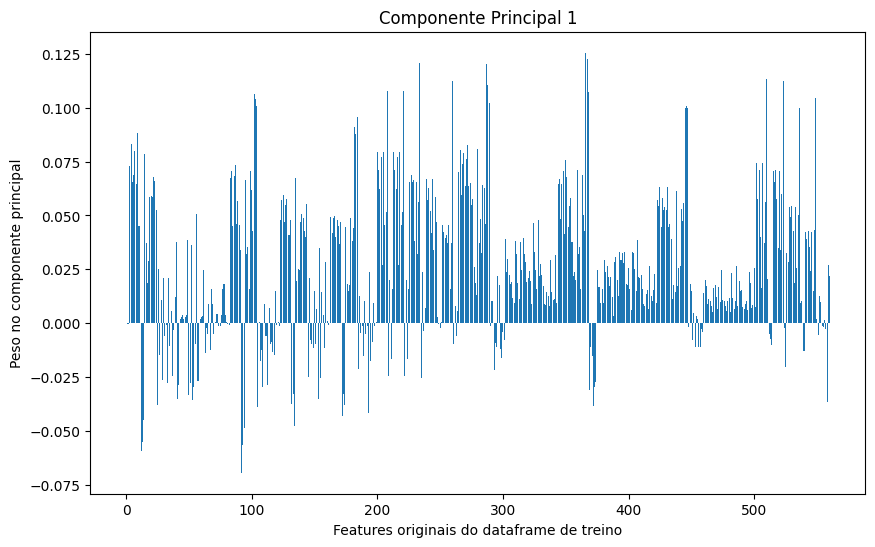

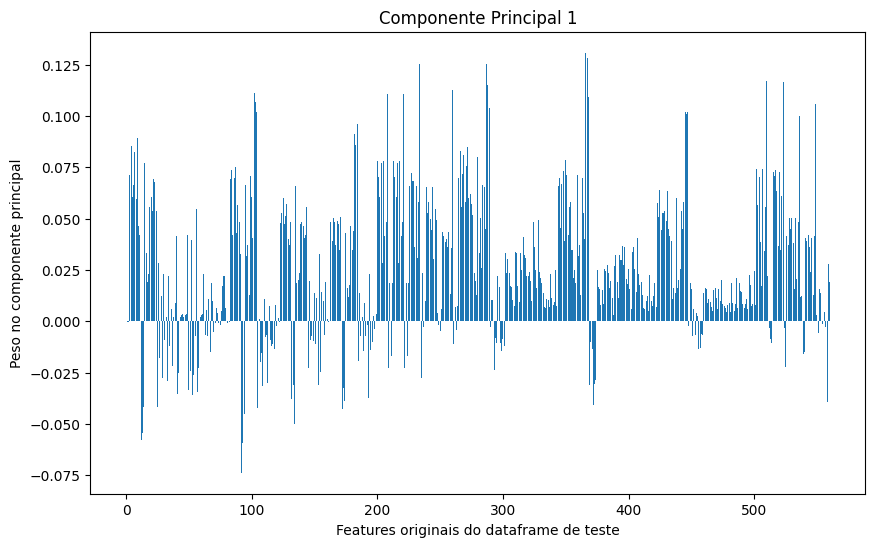

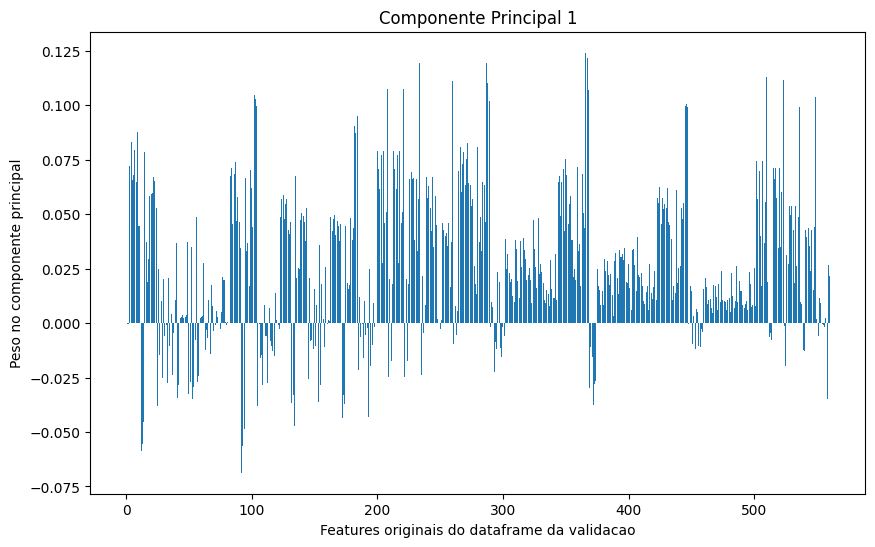

In [6]:
# plotando PCA do treino
components = pca_train.components_

component_to_plot = 0 # primeiro componente = 0

plt.figure(figsize=(10, 6))
plt.bar(range(components.shape[1]), components[component_to_plot])
plt.xlabel('Features originais do dataframe de treino')
plt.ylabel('Peso no componente principal')
plt.title(f'Componente Principal {component_to_plot + 1}')
plt.show()

# plotando PCA do teste
components = pca_test.components_

component_to_plot = 0 # primeiro componente = 0

plt.figure(figsize=(10, 6))
plt.bar(range(components.shape[1]), components[component_to_plot])
plt.xlabel('Features originais do dataframe de teste')
plt.ylabel('Peso no componente principal')
plt.title(f'Componente Principal {component_to_plot + 1}')
plt.show()

# plotando PCA da validacao
components = pca_val.components_

component_to_plot = 0 # primeiro componente = 0

plt.figure(figsize=(10, 6))
plt.bar(range(components.shape[1]), components[component_to_plot])
plt.xlabel('Features originais do dataframe da validacao')
plt.ylabel('Peso no componente principal')
plt.title(f'Componente Principal {component_to_plot + 1}')
plt.show()

### Autoencoder
- reduzir dimensionalidade do dataset para 360 (indicado pelo dataset que o professor irá usar)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.Sigmoid(),
            nn.Linear(512, 256),
            nn.Sigmoid(),
            nn.Linear(256, latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.Sigmoid(),
            nn.Linear(256, 512),
            nn.Sigmoid(),
            nn.Linear(512, input_dim),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
# Converter para tensores PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# Configurar o DataLoader
X_tensor_dataset_train = TensorDataset(X_train_tensor)
X_tensor_dataset_test = TensorDataset(X_test_tensor)
X_tensor_dataset_val = TensorDataset(X_val_tensor)
train_loader = DataLoader(X_tensor_dataset_train, batch_size=64, shuffle=True)
test_loader = DataLoader(X_tensor_dataset_test, batch_size=64, shuffle=True)
val_loader = DataLoader(X_tensor_dataset_val, batch_size=64, shuffle=True)

# Configurar o Autoencoder
input_dim = 561
latent_dim = 360
autoencoder_train = Autoencoder(input_dim, latent_dim)
autoencoder_test = Autoencoder(input_dim, latent_dim)
autoencoder_val = Autoencoder(input_dim, latent_dim)

# Definir a função de perda e o otimizador
criterion = nn.MSELoss()
optimizer_train = optim.Adam(autoencoder_train.parameters(), lr=0.001)
optimizer_test = optim.Adam(autoencoder_test.parameters(), lr=0.001)
optimizer_val = optim.Adam(autoencoder_val.parameters(), lr=0.001)

In [7]:
# Treinar o Autoencoder para dataframe de treino
num_epochs = 300
for epoch in range(num_epochs):
    for data in train_loader:
        inputs = data[0]
        optimizer_train.zero_grad()
        outputs = autoencoder_train(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer_train.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    reconstructed = autoencoder_train(X_train_tensor)
    mse = nn.MSELoss()(X_train_tensor, reconstructed).item()
    print(f'MSE: {mse:.4f}')
    
# Obter o espaço latente das suas features
X_autoencoder_train = autoencoder_train.encoder(X_train_tensor).detach().numpy()

Epoch [1/300], Loss: 0.0402
Epoch [2/300], Loss: 0.0357
Epoch [3/300], Loss: 0.0323
Epoch [4/300], Loss: 0.0326
Epoch [5/300], Loss: 0.0327
Epoch [6/300], Loss: 0.0278
Epoch [7/300], Loss: 0.0294
Epoch [8/300], Loss: 0.0289
Epoch [9/300], Loss: 0.0279
Epoch [10/300], Loss: 0.0284
Epoch [11/300], Loss: 0.0273
Epoch [12/300], Loss: 0.0230
Epoch [13/300], Loss: 0.0251
Epoch [14/300], Loss: 0.0263
Epoch [15/300], Loss: 0.0245
Epoch [16/300], Loss: 0.0230
Epoch [17/300], Loss: 0.0224
Epoch [18/300], Loss: 0.0227
Epoch [19/300], Loss: 0.0225
Epoch [20/300], Loss: 0.0254
Epoch [21/300], Loss: 0.0215
Epoch [22/300], Loss: 0.0245
Epoch [23/300], Loss: 0.0185
Epoch [24/300], Loss: 0.0221
Epoch [25/300], Loss: 0.0189
Epoch [26/300], Loss: 0.0196
Epoch [27/300], Loss: 0.0209
Epoch [28/300], Loss: 0.0198
Epoch [29/300], Loss: 0.0203
Epoch [30/300], Loss: 0.0227
Epoch [31/300], Loss: 0.0190
Epoch [32/300], Loss: 0.0216
Epoch [33/300], Loss: 0.0194
Epoch [34/300], Loss: 0.0189
Epoch [35/300], Loss: 0

In [8]:
# Treinar o Autoencoder para dataframe de teste
num_epochs = 300
for epoch in range(num_epochs):
    for data in test_loader:
        inputs = data[0]
        optimizer_test.zero_grad()
        outputs = autoencoder_test(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer_test.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    reconstructed = autoencoder_test(X_test_tensor)
    mse = nn.MSELoss()(X_test_tensor, reconstructed).item()
    print(f'MSE: {mse:.4f}')
    
# Obter o espaço latente das suas features
X_autoencoder_test = autoencoder_test.encoder(X_test_tensor).detach().numpy()

Epoch [1/300], Loss: 0.0886
Epoch [2/300], Loss: 0.0719
Epoch [3/300], Loss: 0.0300
Epoch [4/300], Loss: 0.0352
Epoch [5/300], Loss: 0.0374
Epoch [6/300], Loss: 0.0287
Epoch [7/300], Loss: 0.0313
Epoch [8/300], Loss: 0.0230
Epoch [9/300], Loss: 0.0171
Epoch [10/300], Loss: 0.0249
Epoch [11/300], Loss: 0.0390
Epoch [12/300], Loss: 0.0388
Epoch [13/300], Loss: 0.0296
Epoch [14/300], Loss: 0.0179
Epoch [15/300], Loss: 0.0229
Epoch [16/300], Loss: 0.0193
Epoch [17/300], Loss: 0.0248
Epoch [18/300], Loss: 0.0264
Epoch [19/300], Loss: 0.0197
Epoch [20/300], Loss: 0.0260
Epoch [21/300], Loss: 0.0225
Epoch [22/300], Loss: 0.0387
Epoch [23/300], Loss: 0.0315
Epoch [24/300], Loss: 0.0235
Epoch [25/300], Loss: 0.0184
Epoch [26/300], Loss: 0.0176
Epoch [27/300], Loss: 0.0325
Epoch [28/300], Loss: 0.0228
Epoch [29/300], Loss: 0.0212
Epoch [30/300], Loss: 0.0275
Epoch [31/300], Loss: 0.0216
Epoch [32/300], Loss: 0.0237
Epoch [33/300], Loss: 0.0187
Epoch [34/300], Loss: 0.0270
Epoch [35/300], Loss: 0

In [9]:
# Treinar o Autoencoder para dataframe de validacao
num_epochs = 300
for epoch in range(num_epochs):
    for data in val_loader:
        inputs = data[0]
        optimizer_val.zero_grad()
        outputs = autoencoder_val(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer_val.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

with torch.no_grad():
    reconstructed = autoencoder_val(X_val_tensor)
    mse = nn.MSELoss()(X_val_tensor, reconstructed).item()
    print(f'MSE: {mse:.4f}')
    
# Obter o espaço latente das suas features
X_autoencoder_val = autoencoder_val.encoder(X_val_tensor).detach().numpy()

Epoch [1/300], Loss: 0.1145
Epoch [2/300], Loss: 0.1051
Epoch [3/300], Loss: 0.0540
Epoch [4/300], Loss: 0.0378
Epoch [5/300], Loss: 0.0396
Epoch [6/300], Loss: 0.0399
Epoch [7/300], Loss: 0.0351
Epoch [8/300], Loss: 0.0353
Epoch [9/300], Loss: 0.0349
Epoch [10/300], Loss: 0.0304
Epoch [11/300], Loss: 0.0331
Epoch [12/300], Loss: 0.0320
Epoch [13/300], Loss: 0.0299
Epoch [14/300], Loss: 0.0314
Epoch [15/300], Loss: 0.0290
Epoch [16/300], Loss: 0.0341
Epoch [17/300], Loss: 0.0284
Epoch [18/300], Loss: 0.0310
Epoch [19/300], Loss: 0.0269
Epoch [20/300], Loss: 0.0265
Epoch [21/300], Loss: 0.0264
Epoch [22/300], Loss: 0.0305
Epoch [23/300], Loss: 0.0254
Epoch [24/300], Loss: 0.0264
Epoch [25/300], Loss: 0.0286
Epoch [26/300], Loss: 0.0270
Epoch [27/300], Loss: 0.0257
Epoch [28/300], Loss: 0.0255
Epoch [29/300], Loss: 0.0253
Epoch [30/300], Loss: 0.0270
Epoch [31/300], Loss: 0.0261
Epoch [32/300], Loss: 0.0295
Epoch [33/300], Loss: 0.0263
Epoch [34/300], Loss: 0.0269
Epoch [35/300], Loss: 0

In [10]:
print("dimensao do vetor latente de treino: ", X_autoencoder_train.shape)
print("dimensao do vetor latente de teste: ", X_autoencoder_test.shape)
print("dimensao do vetor latente de val: ", X_autoencoder_val.shape)

dimensao do vetor latente de treino:  (5881, 360)
dimensao do vetor latente de teste:  (2947, 360)
dimensao do vetor latente de val:  (1471, 360)


### Criando Dataset para treinar a tarefa de pretexto

In [5]:
class CSVDataset(Dataset):
    def __init__(self, df, transform=None):
        self.data = df
        self.transform = transform

        # self.features = self.data.iloc[:, :-1].values
        # self.labels = self.data.iloc[:, -1].values

        # self.label_encoder = LabelEncoder()
        # self.labels = self.label_encoder.fit_transform(self.labels)

        if self.transform:
            self.features = self.transform.fit_transform(self.data)
        else:
            self.features = self.data
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        # sample = {
        #     'features': torch.tensor(self.features[idx], dtype=torch.float32),
        #     'label': torch.tensor(self.labels[idx], dtype=torch.long)
        #     }
        sample = torch.tensor(self.features[idx], dtype=torch.float32).unsqueeze(0)
        # print(sample)
        return sample
    
    # def get_label_encoder(self):
    #     return self.label_encoder

In [12]:
# # Alterar as séries temporais para criar novas instâncias de dados.
# # Aumentar a quantidade de dados de treinamento e melhorar a generalização do modelo.
# # Jittering: Adicionar ruído aleatório.
# # Scaling: Multiplicar por um fator aleatório.
# # Time Shifting: Deslocar a série no tempo.
# class Jitter:
#     def __init__(self, sigma=0.01):
#         self.sigma = sigma

#     def __call__(self, x):
#         noise = np.random.normal(loc=0, scale=self.sigma, size=x.shape)
#         return x + noise

# class Scaling:
#     def __init__(self, sigma=0.1):
#         self.sigma = sigma

#     def __call__(self, x):
#         factor = np.random.normal(loc=1.0, scale=self.sigma)
#         return x * factor

# class TimeShift:
#     def __init__(self, max_shift=50):
#         self.max_shift = max_shift

#     def __call__(self, x):
#         shift = np.random.randint(-self.max_shift, self.max_shift)
#         return np.roll(x, shift)

# # Converter dados do domínio do tempo para o domínio da frequência
# # Capturar padrões de frequência que podem ser úteis para reconhecer atividades com características periódicas
# class FourierTransform:
#     def __call__(self, x):
#         return np.fft.fft(x)

# # Aplicar transformacao logaritmica
# # Reduzir a variabilidade dos dados, especialmente quando existem diferenças de magnitude significativas.
# class LogTransform:
#     def __call__(self, x):
#         return np.log1p(x)

# # classe de transformacoes nos dados
# class Compose:
#     def __init__(self, transforms):
#         self.transforms = transforms

#     def __call__(self, x):
#         for t in self.transforms:
#             if callable(t):
#                 x = t(x)
#             else:
#                 x = t.fit_transform(x)
#         return x

In [6]:
def createDataLoader(train_dataframe, val_dataframe, test_dataframe, batch_size=32):
    # train_transform = Compose([
    #     StandardScaler(),
    #     TimeShift(max_shift=10),
    #     Jitter(sigma=0.01)
    # ])
    # valid_test_transform = Compose([
    #     StandardScaler()
    # ])

    train_dataset = CSVDataset(train_dataframe, transform=StandardScaler())
    val_dataset = CSVDataset(val_dataframe, transform=StandardScaler())
    test_dataset = CSVDataset(test_dataframe, transform=StandardScaler())

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader

In [7]:
train_dataset, val_dataset, test_dataset, train_loader, val_loader, test_loader = createDataLoader(
    fs_train, # X_pca_train, X_autoencoder_train
    fs_val, # X_pca_val, X_autoencoder_val
    fs_test # X_pca_test, X_autoencoder_test
    )

In [8]:
print(len(train_dataset), len(train_loader))
print(len(val_dataset), len(val_loader))
print(len(test_dataset), len(test_loader))

5881 184
1471 46
2947 93


In [9]:
for x in train_loader:
    print(x.shape) # (batch_size, seq_len, input_dim)
    break

torch.Size([32, 1, 360])


In [10]:
for batch_idx, batch in enumerate(train_loader):
    print(batch.shape)
    break

torch.Size([32, 1, 360])


In [14]:
# encoded_labels = [0, 1, 2, 3, 4, 5]  # Exemplo de labels codificados
# decoded_labels = train_dataset.get_label_encoder().inverse_transform(encoded_labels)
# print(decoded_labels)

In [15]:
# class VAE(nn.Module):
#     def __init__(self, input_dim, device, hidden_dim=400, latent_dim=20):
#         super(VAE, self).__init__()

#         # encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, latent_dim * 2),
#             nn.ReLU()
#             )
        
#         # latente mean and variance
#         # self.mean_layer = nn.Linear(latent_dim, 2)
#         # self.logvar_layer = nn.Linear(latent_dim, 2)

#         # decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, input_dim),
#             # nn.Sigmoid()
#             nn.ReLU()
#         )
    
#     # def encode(self, x):
#     #     x = self.encoder(x)
#     #     return self.mean_layer(x), self.logvar_layer(x)
    
#     def reparameterization(self, mean, var):
#         std = torch.exp(0.5 * var)
#         eps = torch.randn_like(std)
#         return mean + eps * std
#         # epsilon = torch.randn_like(var).to(device)
#         # return mean + var * epsilon
    
#     # def decode(self, x):
#     #     return self.decoder(x)
    
#     def forward(self, x):
#         z_mean_logvar = self.encoder(x)
#         mean, logvar = torch.chunk(z_mean_logvar, 2, dim=-1)
#         z = self.reparameterization(mean, logvar)
#         x_hat = self.decoder(z)
#         return x_hat, mean, logvar

In [11]:
class TemporalVAE(nn.Module):
    def __init__(self, device, input_dim, hidden_dim, latent_dim, num_layers=1):
        super(TemporalVAE, self).__init__()

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=0.2)
        self.hidden2mean = nn.Linear(hidden_dim, latent_dim)
        self.hidden2logvar = nn.Linear(hidden_dim, latent_dim)
        
        self.latent2hidden = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, input_dim, num_layers, batch_first=True, bidirectional=False, dropout=0.2)
        self.output_layer = nn.Linear(input_dim, input_dim)
        self.dropout = nn.Dropout(0.2)
    
    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(device)
        return mean + eps * std
    
    def encode(self, x):
        residual = x
        output, (h_n, _) = self.encoder_lstm(x)
        output = output[:, :, :output.size(2)//2] + output[:, :, output.size(2)//2:]
        h_n = output[:, -1, :]
        # h_n = h_n[-1, :, :]
        h_n = self.dropout(h_n)
        mean = self.hidden2mean(h_n) # sigmoid (obs: se usar relu vai zerar)
        logvar = self.hidden2logvar(h_n) # sigmoid (obs: se usar relu vai zerar)
        return mean, logvar, residual
    
    def decode(self, z, seq_len, residual):
        # hidden = self.latent2hidden(z).unsqueeze(0).repeat(seq_len, 1, 1).transpose(0, 1)
        hidden = self.latent2hidden(z).unsqueeze(1).repeat(1, seq_len, 1)

        output, _ = self.decoder_lstm(hidden)
        output = self.dropout(output)

        # output += residual

        output = self.output_layer(output)
        return output
    
    def forward(self, x):
        mean, logvar, residual = self.encode(x)
        # print(mean)
        z = self.reparameterize(mean, logvar)
        seq_len = x.size(1)
        recon_x = self.decode(z, seq_len, residual)
        return recon_x, mean, logvar

In [12]:
# Definir parâmetros do modelo
input_dim = train_dataset.features.shape[1]
hidden_dim = 128 # 400
latent_dim = 64 # 20
num_layers = 2
learning_rate = 0.001
# batch_size = 32
epochs = 100

print("input_dim: ", input_dim)

input_dim:  360


In [13]:
def loss_function(x, x_hat, mean, log_var):
    # reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction='sum') # mse
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [14]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_uniform_(m.weight)
        init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                init.orthogonal_(param.data)
            elif 'bias' in name:
                init.zeros_(param.data)

In [15]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # cuda
device = torch.device('cpu') # essa linha só está aqui para fazer o model.apply() funcionar, porque tem uma funcao de inicializacao que nao funciona no MPS atualmente
print(device)

# model = VAE(input_dim, device).to(device) # baseline
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)
model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

cpu


In [16]:
print(model)

TemporalVAE(
  (encoder_lstm): LSTM(360, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (hidden2mean): Linear(in_features=128, out_features=64, bias=True)
  (hidden2logvar): Linear(in_features=128, out_features=64, bias=True)
  (latent2hidden): Linear(in_features=64, out_features=128, bias=True)
  (decoder_lstm): LSTM(128, 360, num_layers=2, batch_first=True, dropout=0.2)
  (output_layer): Linear(in_features=360, out_features=360, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [17]:
def evaluate_metrics(x, recon_x):
    x = x.view(-1).detach().cpu().numpy()
    recon_x = recon_x.view(-1).detach().cpu().numpy()
    
    mse = mean_squared_error(x, recon_x)
    mae = mean_absolute_error(x, recon_x)
    rmse = mse ** 0.5
    r2 = r2_score(x, recon_x)
    
    return mse, mae, rmse, r2

def train_vae(model, train_loader, optimizer, device):
    model.train()
    overall_loss = 0
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0
    for x in train_loader:
        data = x.to(device)
        optimizer.zero_grad()
        x_hat, mean, log_var = model(data)
        loss = loss_function(data, x_hat, mean, log_var)
        loss.backward()
        optimizer.step()
        overall_loss += loss.item()
        mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
        mse_total += mse
        mae_total += mae
        rmse_total += rmse
        r2_total += r2
    avg_train_loss = overall_loss / len(train_loader.dataset)
    avg_mse = mse_total / len(train_loader.dataset)
    avg_mae = mae_total / len(train_loader.dataset)
    avg_rmse = rmse_total / len(train_loader.dataset)
    avg_r2 = r2_total / len(train_loader.dataset)
    return avg_train_loss, avg_mse, avg_mae, avg_rmse, avg_r2

def val_vae(model, val_loader, device):
    model.eval()
    overall_loss = 0
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0
    with torch.no_grad():
        for x in val_loader:
            data = x.to(device)
            x_hat, mean, log_var = model(data)
            loss = loss_function(data, x_hat, mean, log_var)
            overall_loss += loss.item()
            mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse
            r2_total += r2
    avg_val_loss = overall_loss / len(val_loader.dataset)
    avg_mse = mse_total / len(train_loader.dataset)
    avg_mae = mae_total / len(train_loader.dataset)
    avg_rmse = rmse_total / len(train_loader.dataset)
    avg_r2 = r2_total / len(train_loader.dataset)
    return avg_val_loss, avg_mse, avg_mae, avg_rmse, avg_r2

In [18]:
def train(model, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    
    train_mse = []
    train_mae = []
    train_rmse = []
    train_r2 = []

    val_mse = []
    val_mae = []
    val_rmse = []
    val_r2 = []
    for epoch in range(epochs):
        train_loss, mse_train, mae_train, rmse_train, r2_train = train_vae(model=model, train_loader=train_loader, optimizer=optimizer, device=device)
        val_loss, mse_val, mae_val, rmse_val, r2_val = val_vae(model=model, val_loader=test_loader, device=device)
        train_losses.append(train_loss)
        train_mse.append(mse_train)
        train_mae.append(mae_train)
        train_rmse.append(rmse_train)
        train_r2.append(r2_train)

        val_losses.append(val_loss)
        val_mse.append(mse_val)
        val_mae.append(mae_val)
        val_rmse.append(rmse_val)
        val_r2.append(r2_val)
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train MSE: {mse_train}, Val MSE: {mse_val}, Train MAE: {mae_train}, Val MAE: {mae_val}, Val R2: {r2_val}')
    return train_losses, val_losses, val_losses, train_mse, train_mae, train_rmse, train_r2, val_mse, val_mae, val_rmse, val_r2

In [19]:
train_losses, val_losses, val_losses, train_mse, train_mae, train_rmse, train_r2, val_mse, val_mae, val_rmse, val_r2 = train(model, optimizer, epochs, device)

Epoch [1/100], Train Loss: 140.2533, Val Loss: 110.3379, Train MSE: 0.011423474579639043, Val MSE: 0.004459162027814359, Train MAE: 0.011059375623926138, Val MAE: 0.004825069243618875, Val R2: 0.01127598790809464
Epoch [2/100], Train Loss: 106.4705, Val Loss: 113.6003, Train MSE: 0.008502637980452931, Val MSE: 0.004591868505897905, Train MAE: 0.008849054810607987, Val MAE: 0.004851252504441836, Val R2: 0.011184053069534522
Epoch [3/100], Train Loss: 98.4378, Val Loss: 103.3076, Train MSE: 0.007794704961596328, Val MSE: 0.004229735669848911, Train MAE: 0.008398080977873016, Val MAE: 0.00473731328254856, Val R2: 0.011531686817296324
Epoch [4/100], Train Loss: 95.6564, Val Loss: 95.3794, Train MSE: 0.007554905341811132, Val MSE: 0.0038409272556887905, Train MAE: 0.00815791392829057, Val MAE: 0.004357765894462373, Val R2: 0.011957082481251305
Epoch [5/100], Train Loss: 87.4681, Val Loss: 86.4019, Train MSE: 0.006869614532236703, Val MSE: 0.0034598945352601836, Train MAE: 0.0077518030299233

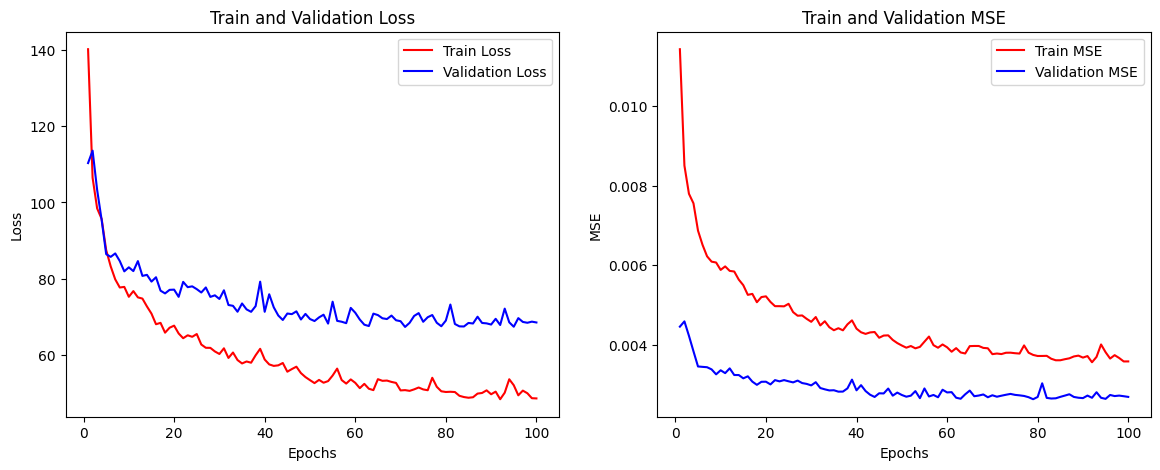

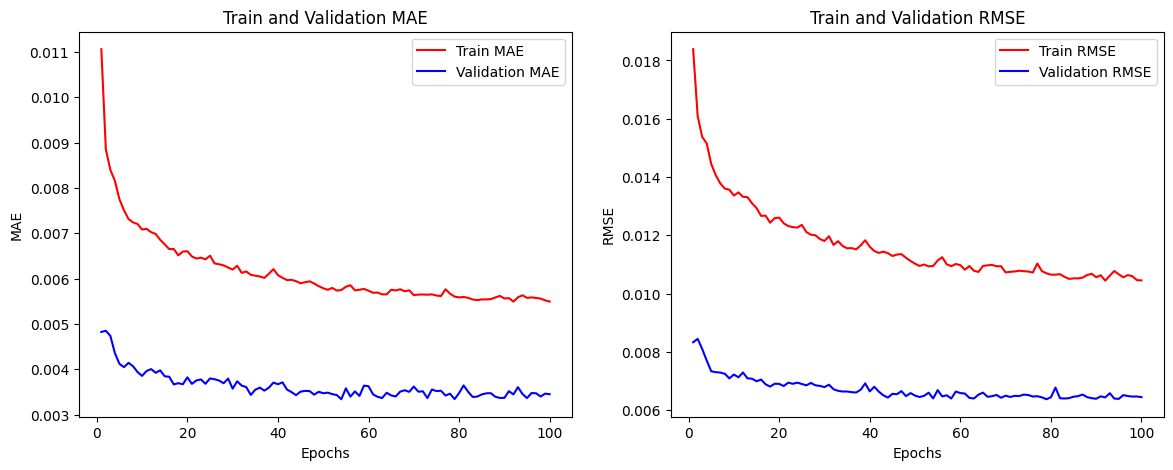

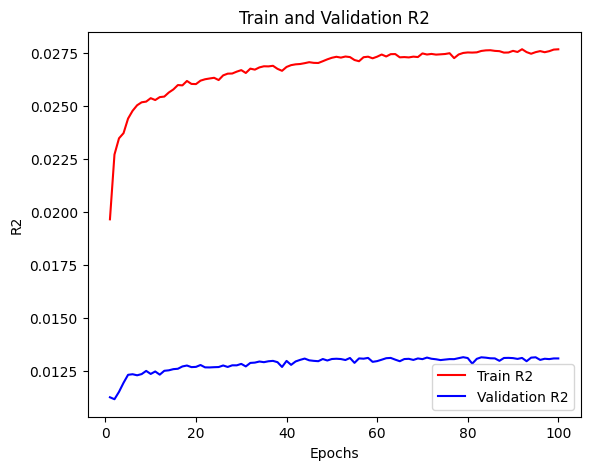

In [20]:
# Plotando a perda e a precisão do modelo sem augmentation
epocas = range(1, epochs + 1) # é 152 epocas porque com early stopping so rodou 152 epocas

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_losses, 'r', label='Train Loss')
plt.plot(epocas, val_losses, 'b', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_mse, 'r', label='Train MSE')
plt.plot(epocas, val_mse, 'b', label='Validation MSE')
plt.title('Train and Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_mae, 'r', label='Train MAE')
plt.plot(epocas, val_mae, 'b', label='Validation MAE')
plt.title('Train and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epocas, train_rmse, 'r', label='Train RMSE')
plt.plot(epocas, val_rmse, 'b', label='Validation RMSE')
plt.title('Train and Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

plt.show()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epocas, train_r2, 'r', label='Train R2')
plt.plot(epocas, val_r2, 'b', label='Validation R2')
plt.title('Train and Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend()

plt.show()

In [21]:
# salvando modelo
torch.save(model.state_dict(), "model/vae.pth")

In [22]:
# carregando modelo
model_path = "model/vae.pth"

# Criar uma instância do modelo
model = TemporalVAE(device, input_dim, hidden_dim, latent_dim, num_layers).to(device)

# Carregar o estado salvo
state_dict = torch.load(model_path)

# Carregar o estado no modelo
model.load_state_dict(state_dict)

<All keys matched successfully>

Average MSE: 0.0054, Average MAE: 0.0069, Average RMSE: 0.0129, Average R²: 0.0262


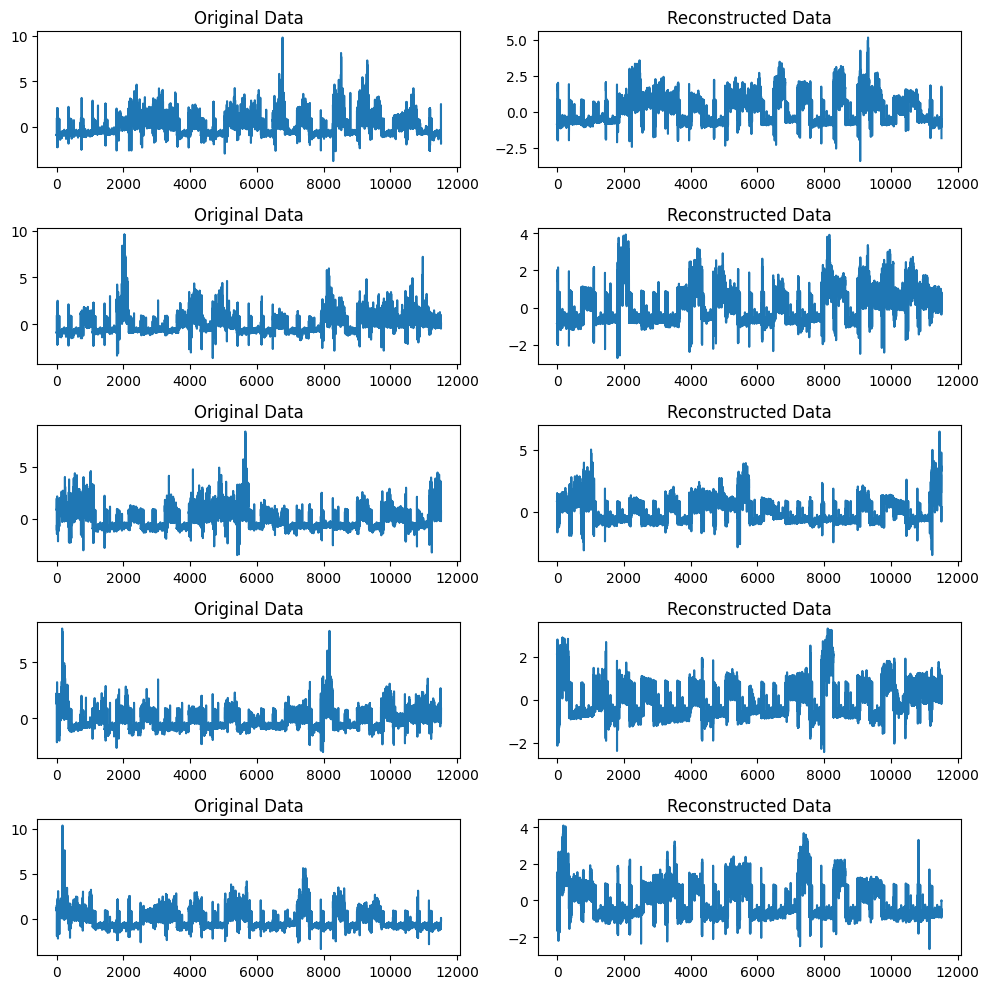

In [23]:
def evaluate_similarity(model, data_loader, device):
    model.eval()
    mse_total = 0
    mae_total = 0
    rmse_total = 0
    r2_total = 0

    with torch.no_grad():
        for x in data_loader:
            data = x.to(device)
            x_hat, _, _ = model(data)
            
            # Calcular métricas de similaridade
            mse, mae, rmse, r2 = evaluate_metrics(data, x_hat)
            mse_total += mse
            mae_total += mae
            rmse_total += rmse
            r2_total += r2

    avg_mse = mse_total / len(data_loader.dataset)
    avg_mae = mae_total / len(data_loader.dataset)
    avg_rmse = rmse_total / len(data_loader.dataset)
    avg_r2 = r2_total / len(data_loader.dataset)

    return avg_mse, avg_mae, avg_rmse, avg_r2

def plot_reconstruction(data_loader, model, device, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))
    with torch.no_grad():
        for i, x in enumerate(data_loader):
            if i >= num_samples:
                break
            data = x.to(device)
            x_hat, _, _ = model(data)
            
            # original = data[0].cpu().numpy()
            # reconstructed = x_hat[0].cpu().numpy()
            original = data.view(-1).detach().cpu().numpy()
            reconstructed = x_hat.view(-1).detach().cpu().numpy()
            
            axs[i, 0].plot(original, label='Original')
            axs[i, 1].plot(reconstructed, label='Reconstructed')
            
            axs[i, 0].set_title('Original Data')
            axs[i, 1].set_title('Reconstructed Data')
    
    plt.tight_layout()
    plt.show()

avg_mse, avg_mae, avg_rmse, avg_r2 = evaluate_similarity(model, test_loader, device)
print(f'Average MSE: {avg_mse:.4f}, Average MAE: {avg_mae:.4f}, Average RMSE: {avg_rmse:.4f}, Average R²: {avg_r2:.4f}')

plot_reconstruction(test_loader, model, device)

In [29]:
# # exemplo de backbone importado para downstrem task

# import torch
# import torch.nn as nn
# import torch.optim as optim

# class Encoder(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 128)
#         self.fc2_mu = nn.Linear(128, latent_dim)
#         self.fc2_logvar = nn.Linear(128, latent_dim)

#     def forward(self, x):
#         h = torch.relu(self.fc1(x))
#         mu = self.fc2_mu(h)
#         logvar = self.fc2_logvar(h)
#         return mu, logvar

# class Decoder(nn.Module):
#     def __init__(self, latent_dim, output_dim):
#         super(Decoder, self).__init__()
#         self.fc3 = nn.Linear(latent_dim, 128)
#         self.fc4 = nn.Linear(128, output_dim)

#     def forward(self, z):
#         h = torch.relu(self.fc3(z))
#         x_recon = torch.sigmoid(self.fc4(h))
#         return x_recon

# class VAE(nn.Module):
#     def __init__(self, input_dim, latent_dim):
#         super(VAE, self).__init__()
#         self.encoder = Encoder(input_dim, latent_dim)
#         self.decoder = Decoder(latent_dim, input_dim)

#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std

#     def forward(self, x):
#         mu, logvar = self.encoder(x)
#         z = self.reparameterize(mu, logvar)
#         x_recon = self.decoder(z)
#         return x_recon, mu, logvar

# def loss_function(recon_x, x, mu, logvar):
#     BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD

# # Hyperparameters
# input_dim = 100  # Exemplo, altere de acordo com os seus dados
# latent_dim = 20
# learning_rate = 0.001
# num_epochs = 50

# # Model, optimizer
# vae = VAE(input_dim, latent_dim)
# optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

# # Training loop
# for epoch in range(num_epochs):
#     for x in data_loader:  # Assumindo que você tem um data_loader definido
#         optimizer.zero_grad()
#         x_recon, mu, logvar = vae(x)
#         loss = loss_function(x_recon, x, mu, logvar)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')

# class ActivityClassifier(nn.Module):
#     def __init__(self, encoder, latent_dim, num_classes):
#         super(ActivityClassifier, self).__init__()
#         self.encoder = encoder
#         self.fc = nn.Linear(latent_dim, num_classes)

#     def forward(self, x):
#         mu, logvar = self.encoder(x)
#         return self.fc(mu)  # Utilizando mu como a representação latente

# # Hyperparameters
# num_classes = 10  # Exemplo, altere conforme necessário
# learning_rate = 0.001
# num_epochs = 50

# # Model, optimizer
# activity_classifier = ActivityClassifier(vae.encoder, latent_dim, num_classes)
# optimizer = optim.Adam(activity_classifier.parameters(), lr=learning_rate)
# criterion = nn.CrossEntropyLoss()

# # Training loop for the downstream task
# for epoch in range(num_epochs):
#     for x, y in labeled_data_loader:  # Assumindo que você tem um labeled_data_loader definido
#         optimizer.zero_grad()
#         logits = activity_classifier(x)
#         loss = criterion(logits, y)
#         loss.backward()
#         optimizer.step()
#     print(f'Epoch {epoch}, Loss: {loss.item()}')